In [1]:
suppressMessages(library(scran))
library(BiocParallel)
library(parallel)
library(muscat)
suppressMessages(library(limma))
suppressMessages(library(EnhancedVolcano))
library(patchwork)
suppressMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
library(ggsci)

In [2]:
seuratobj_full=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [3]:
DefaultAssay(seuratobj_full)='RNA'

In [4]:
#Preprocess seuratobj_full
seuratobj_full=DietSeurat(
  seuratobj_full,
  counts = TRUE,
  data = T,
  scale.data = FALSE,
  features = NULL,
  assays = c('RNA','ADT'),
  dimreducs = F,
  graphs = F
)
#seuratobj_full <- NormalizeData(seuratobj_full, normalization.method = "CLR", margin = 2, assay = "ADT")
seuratobj_full@meta.data=seuratobj_full@meta.data %>% 
mutate(timepoint=ifelse(days.since.apharesis<2, 'apharesis','post_infusion'))

seuratobj_full$idecabtagene_pos=GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['idecabtagene',]>0
seuratobj_full$ciltacabtagene_pos=GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['ciltacabtagene',]>0

#variable for aggregating ADTs with seurat function
seuratobj_full@meta.data=seuratobj_full@meta.data %>% unite(agg_factor, WNN_l2, orig.ident, remove = F, sep ='*') 

#Classify PR as nonCR
seuratobj_full@meta.data=seuratobj_full@meta.data %>% mutate(response=ifelse(remission.after.CAR=='CR', 'CR', 'nonCR'))

In [5]:
# For joining with pseudobulked ADT
response_metadata=seuratobj_full@meta.data %>% select(orig.ident, response) %>% distinct

In [6]:
#subset for non CART and main cell types
seuratobj=seuratobj_full[,                       
                        seuratobj_full$WNN_agg!='Others'&
                        seuratobj_full$idecabtagene_pos==F&
                         seuratobj_full$ciltacabtagene_pos==F
                       ]

In [7]:
plasma_ADT=c('CD38', 'CD269', 'CD319')

In [8]:
getpseudobulk=function(seuratobj_sub){
    
seuratobj_sub <- NormalizeData(seuratobj_sub, normalization.method = "CLR", margin = 2, assay = "ADT", verbose = F)

pbmc.sce.adt <- as.SingleCellExperiment(seuratobj_sub, assay='ADT')

pb.adt <- summarizeAssayByGroup(pbmc.sce.adt,
                                ids=pbmc.sce.adt$agg_factor,
                                assay.type='logcounts',
                                statistics='mean',                            
                                BPPARAM = MulticoreParam(workers=8)
                               )

pb.adt.sce=as(pb.adt, "SingleCellExperiment") #convert from summarisedexperiement to SCE
pb.adt.seurat <- as.Seurat(pb.adt.sce, counts=NULL, data='mean') #Convert to seurat

#Split factor used for pseudobulking back to 2 columns
pb.adt.seurat@meta.data=pb.adt.seurat@meta.data %>% separate(ids, into=c('WNN_l2','orig.ident'), sep='\\*') 

pb.adt.seurat=pb.adt.seurat[,pb.adt.seurat$ncells>=10] #Only consider group with more than 10 cells

pb.adt.seurat@meta.data=pb.adt.seurat@meta.data %>% rownames_to_column('barcode')  %>%
left_join(response_metadata, by='orig.ident') %>% column_to_rownames('barcode') #Add metadata

#Cell type to omit from comparison becuase not enough replicates (need at least 2)
omit_cluster=pb.adt.seurat@meta.data %>% count(WNN_l2, response) %>% 
pivot_wider(names_from='response', values_from=n, values_fill=0) %>%
pivot_longer(!WNN_l2) %>% filter(value<2) %>% select(WNN_l2) %>% unlist

pb.adt.seurat=pb.adt.seurat[,!pb.adt.seurat$WNN_l2 %in% c(omit_cluster)]  

}

In [19]:
performDE=function(pb.adt.seurat){
    
meanfunc= function(x) {
    return(rowMeans(x))
  }

    
getresADT=function(i, seuratobj){
res_ADT=FindMarkers(seuratobj, subset.ident = i, ident.1 = 'nonCR', ident.2 = 'CR', group.by = 'response', logfc.threshold=0.3,
                    assay='originalexp', min.cells.group = 2, mean.fxn = meanfunc)
    res_ADT %>% rownames_to_column('ADT') %>% mutate(WNN_l2=i)
    
    }

WNN_l2_candidates=sort(unique(pb.adt.seurat$WNN_l2))

Idents(pb.adt.seurat)='WNN_l2'
res_ADT_list=mclapply(WNN_l2_candidates, getresADT, seuratobj=pb.adt.seurat,  mc.cores=8)

res_ADT_sig=bind_rows(res_ADT_list) 
    }

In [10]:
getplots=function(res_ADT_sig, seuratobj, p_threshold=0.05, FC_threshold=0.4, plabel.x=0, expand.y=0.2, omit_clusters=NULL){
#Filter for significant p values
res_ADT_sig=res_ADT_sig %>% filter(p_val<p_threshold, abs(avg_log2FC)>FC_threshold) %>% filter(!WNN_l2 %in% omit_clusters)

#Extract ADT data from seuratobj
ADT_data=GetAssayData(seuratobj_sub, slot='data', assay='ADT')
ADT_data=t(ADT_data) %>% as.data.frame %>% bind_cols(seuratobj_sub@meta.data %>% select(WNN_l2, orig.ident, response))
ADT_data=ADT_data %>% pivot_longer(1:TIGIT, names_to='ADT', values_to='expression')
    
#Split dataframe up for plotting
ADT_plot_list=res_ADT_sig %>% select(ADT, WNN_l2) %>% left_join(ADT_data, by = c("ADT", "WNN_l2")) %>%
unite(split_factor, WNN_l2, ADT, remove = F) %>%
group_by(split_factor) %>% group_split

getADTplots=function(ADT_plot){
newlevels=ADT_plot %>% select(response, orig.ident) %>% distinct %>% arrange(response, orig.ident) %>% group_by(response) %>%
mutate(strsorted=str_sort(orig.ident, numeric=T)) %>% ungroup %>% select(strsorted) %>% unlist

ADT_plot=ADT_plot %>% mutate(orig.ident=factor(orig.ident, levels=newlevels))
    
ADT_annotate=ADT_plot %>% distinct(ADT, WNN_l2, orig.ident,response) %>% left_join(res_ADT_sig) %>% 
    mutate(p_val_text=paste0("p=",round(p_val, 3))) #%>%
     #mutate(group1=1, group2=1, y.position=Inf) 
    
p=ggplot(ADT_plot, aes(x=orig.ident, y=expression,fill=response))+geom_jitter(size=0.1, alpha=0.5, show.legend=F)+geom_violin(alpha=0.5)+
    #geom_boxplot(width=.1)+ 
    stat_summary(fun= "mean",geom = "crossbar", width = 0.5, show.legend=F ) + scale_y_continuous(expand = expansion(add = c(0, expand.y)))+
facet_wrap(~ADT, scale='free_y')+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+ 
    theme(text = element_text(size = 15), axis.title.x=element_blank()) + ggtitle(ADT_plot$WNN_l2[1])+
    geom_text(data=ADT_annotate, mapping =aes(x = 1, y = Inf, label=p_val_text), hjust=plabel.x, vjust   = 2)+
    scale_fill_manual(values = pal_jco("default", alpha = 0.6)(10)[2:1])
    #add_pvalue(ADT_annotate, label="p={p_val}", remove.bracket=T, x=1, hjust=-1, vjust=3, label.size =10)
}

ADTplots=mclapply(ADT_plot_list, getADTplots, mc.cores=8)
}

In [ ]:
# Function to plot Violins sorted by mean expression
plot_marker2=function(seuratobj_sub, markers_plot, cluster_plot, plabel.x=2){

    ADT_data=GetAssayData(seuratobj_sub, slot='data', assay='ADT')
ADT_data=t(ADT_data) %>% as.data.frame %>% bind_cols(seuratobj_sub@meta.data %>% select(WNN_l2, WNN_agg, orig.ident, response))
ADT_data=ADT_data %>% pivot_longer(1:TIGIT, names_to='ADT', values_to='expression')
ADT_plot_list=ADT_data %>% filter(ADT %in% markers_plot, WNN_l2 %in% cluster_plot) %>% group_by(ADT) %>% group_split()

getADTplots=function(ADT_plot){
newlevels=ADT_plot %>% group_by(orig.ident, response, ADT, WNN_agg) %>% summarise(mean_expression=median(expression)) %>% 
arrange(-mean_expression) %>% ungroup %>% select(orig.ident) %>% unlist
ADT_plot=ADT_plot %>% mutate(orig.ident=factor(orig.ident, levels=newlevels))
    
p=ggplot(ADT_plot, aes(x=orig.ident, y=expression,fill=response))+
    geom_jitter(size=0.1, alpha=0.5, show.legend=F, color='black')+geom_violin(alpha=0.5)+
    stat_summary(fun= "median",geom = "crossbar", width = 0.5, show.legend=F)+  
    scale_fill_manual(values = pal_jco("default")(10)[2:1])+
    theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),axis.title.x=element_blank()) + 
    ggtitle(ADT_plot$ADT[1])
    
    }    
ADTplots=lapply(ADT_plot_list, getADTplots)

}

In [12]:
seuratobj_sub=seuratobj[,
                        seuratobj$source=='PB'&
                        seuratobj$timepoint=='apharesis'
                       ]

In [20]:
pb.adt.seurat=getpseudobulk(seuratobj_sub)
res_ADT_sig=performDE(pb.adt.seurat)

In [27]:
ADTplots1=getplots(res_ADT_sig, pb.adt.seurat, p_threshold=0.05, FC_threshold=0.3)

### Differentially expressed ADTs
To test for differentially expressed ADTs, we took the mean of the normalized expressions of each sample and performed a wilcoxon rank sum test of the mean values between the CR and nonCR groups of samples. We took p<0.05 and abs(logFC)>0.3 as cut-offs. The mean expression of each sample is marked in the violin plot with a horizontal bar. 

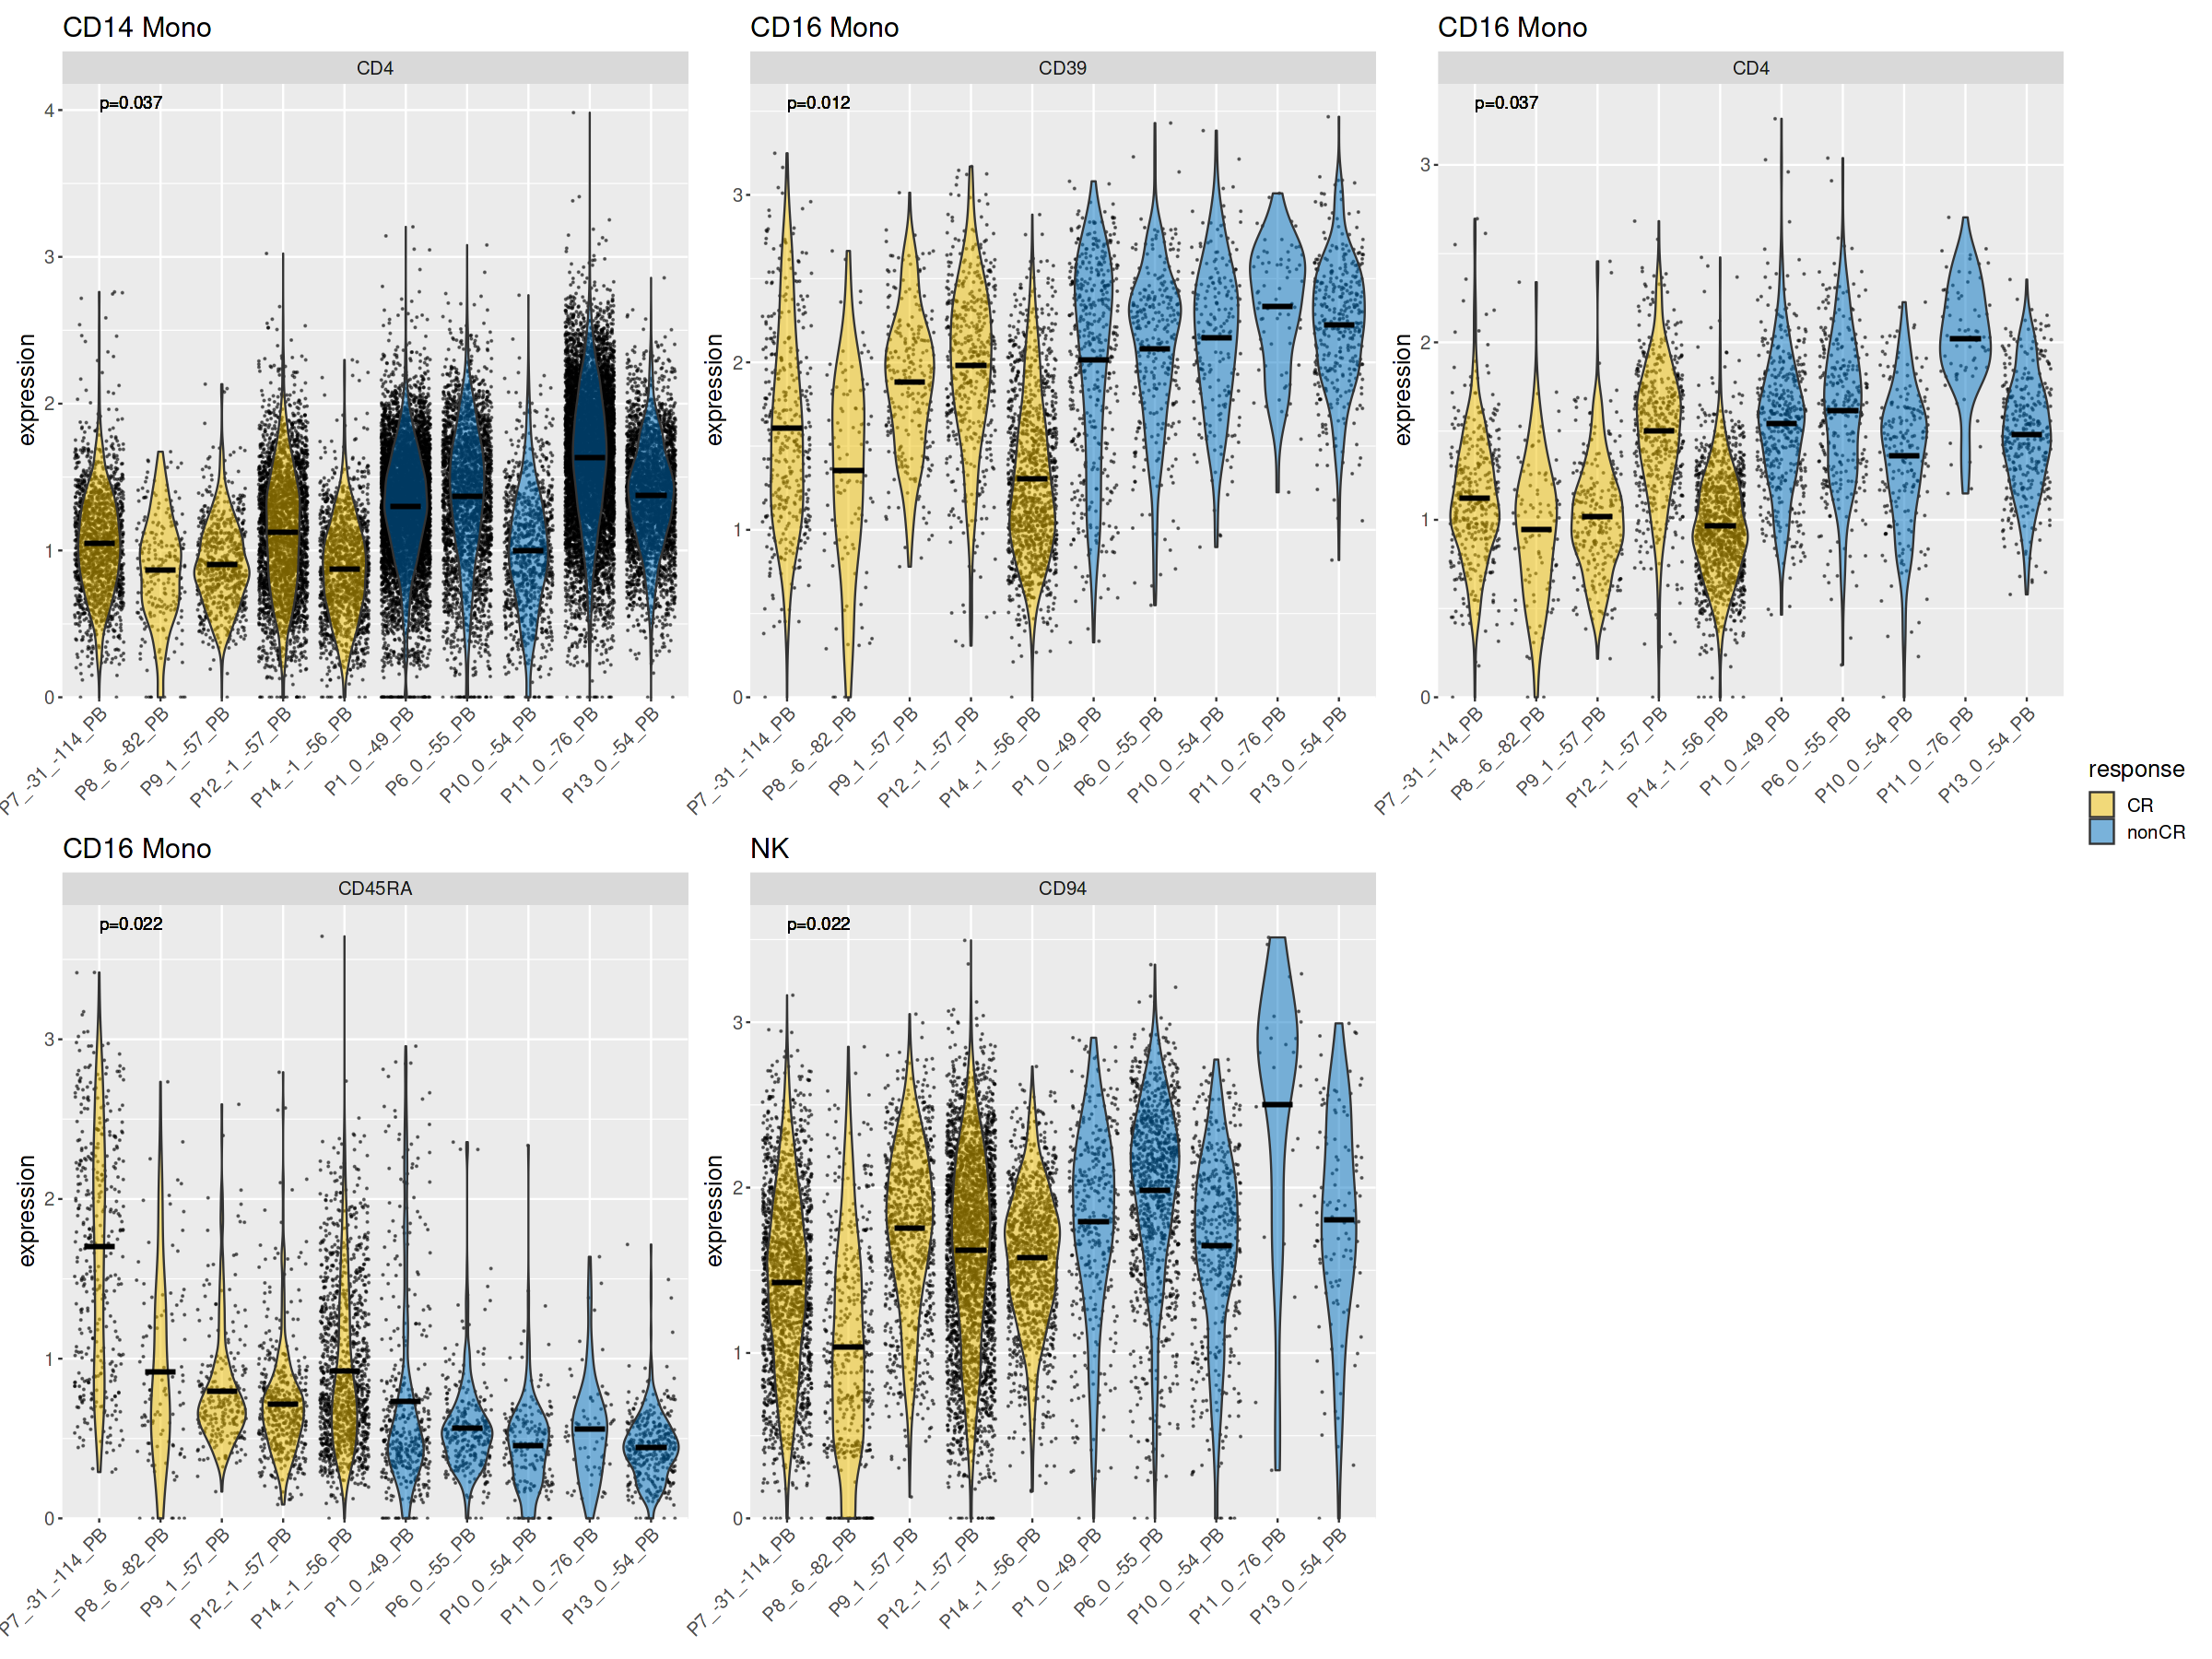

In [28]:
# Figure 4E
options(repr.plot.width=20, repr.plot.height=15)
wrap_plots(ADTplots1)+plot_layout(guides = 'collect')

In [11]:
seuratobj_sub=seuratobj[,
                        seuratobj$source=='PB'&
                        seuratobj$timepoint=='apharesis'&
                        seuratobj$WNN_agg=='Plasma cells'
                       ]

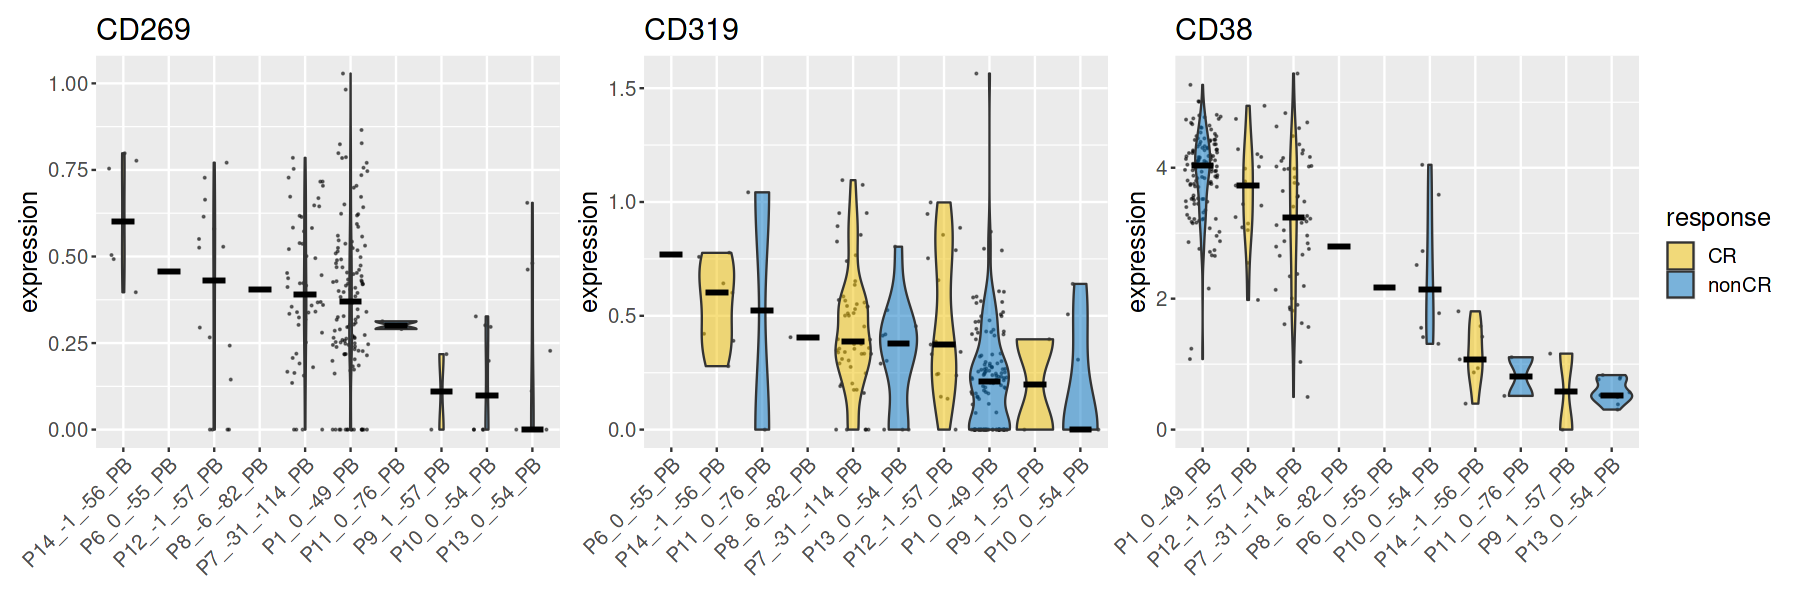

In [145]:
#Figure 8A
plot_list_plasma=plot_marker2(seuratobj_sub, plasma_ADT, "Plasma cells")
options(warn=-1)
options(repr.plot.width=15, repr.plot.height=5)
wrap_plots(plot_list_plasma)+
plot_layout(nrow = 1, guides = 'collect')
options(warn=0)

In [96]:
seuratobj_PI=seuratobj[,
                        seuratobj$source=='PB'&
                        seuratobj$timepoint=='post_infusion'&
                       seuratobj$WNN_agg=='Plasma cells'
                        ]

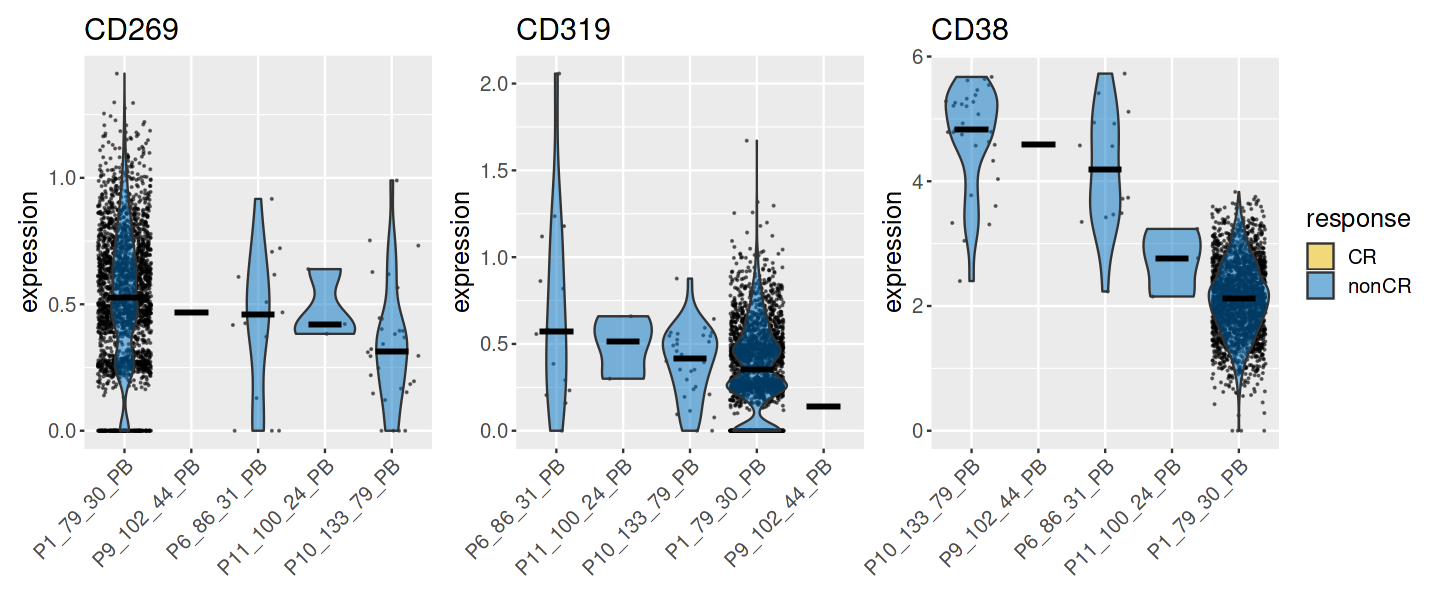

In [143]:
# Figure 8A
plot_list_plasma=plot_marker2(seuratobj_PI, plasma_ADT, "Plasma cells", corral="random", cex=1, jitter=T)
options(warn=-1)
options(repr.plot.width=12, repr.plot.height=5)
wrap_plots(plot_list_plasma)+
plot_layout(nrow = 1, guides = 'collect')
options(warn=0)